In [1]:
# project: p6
# submitter: hseverson4
# partner: none
# hours: 8

In [2]:
import geopandas as gpd
import sqlite3
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np
import rasterio

In [3]:
#Q1: How many counties are in Wisconsin?
wi_counties = gpd.read_file("counties.geojson")
len(wi_counties)

72

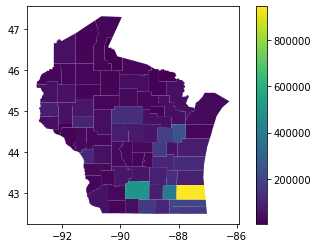

In [4]:
#Q2: What is the population of each county in WI?
wi_counties.plot(column="POP100", legend=True) 
None

In [5]:
conn = sqlite3.connect("counties_tracts.db")

In [6]:
AREALAND = pd.read_sql("""SELECT * FROM counties""", conn)['AREALAND']
wi_counties['AREALAND'] = AREALAND

train, test = train_test_split(wi_counties, random_state=320, test_size=0.25)

In [7]:
#Q3: What are the counties in the test dataset?
list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [8]:
#Q4: How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?
model4 = LinearRegression()
model4.fit(train[["AREALAND"]], train["POP100"])
model4.score(test[["AREALAND"]], test["POP100"])

0.022002661530554857

In [9]:
#Q5: What is the predicted population of a county with 500 square miles of area, according to the model?
sq_meters = 500 * 2.59 * (1000**2)
sq_meters * model4.coef_[0] + model4.intercept_

82032.53073541154

In [10]:
pd.read_sql("""SELECT * FROM tracts""", conn)

,index,NAME,COUNTY,HU100
0,0,Census Tract 9701.01,085,2760
1,1,Census Tract 9710.01,085,1536
2,2,Census Tract 9706.01,085,1208
3,3,Census Tract 9706.02,085,3136
4,4,Census Tract 4301,131,2144
...,...,...,...,...
1404,1404,Census Tract 14,059,2913
1405,1405,Census Tract 15,059,1550
1406,1406,Census Tract 16,059,1286
1407,1407,Census Tract 17,059,1068


In [11]:
hu100 = pd.read_sql("""SELECT *, SUM(HU100) AS hu100 FROM counties
            INNER JOIN tracts ON counties.COUNTY = tracts.COUNTY
            GROUP BY counties.`index`""", conn)["hu100"]
wi_counties["HU100"] = hu100

train, test = train_test_split(wi_counties, random_state=320, test_size=0.25)

In [12]:
#Q6: What are the counties in the test dataset?
list(test["NAME"])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [13]:
#Q7: What are the HU100 values for the counties in the train dataset?
train[['NAME', 'HU100']].set_index("NAME").to_dict()["HU100"]

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

In [14]:
#Q8: How much variance in the POP100 can a LinearRegression model explain based only on HU100?
model8 = LinearRegression()
m8_scores = cross_val_score(model8, train[["HU100"]], train["POP100"])
m8_scores.mean()

0.9652534544116037

In [15]:
#Q9: What is the standard deviation of the cross validation scores from Q7?
m8_scores.std()

0.03704265206670459

In [16]:
#Q10: What is the formula relating POP100 and HU100?
model8.fit(train[["HU100"]], train["POP100"])
model8.score(test[["HU100"]], test["POP100"])
slope = float(round(model8.coef_[0], 2))
intercept = float(round(model8.intercept_, 2))
f"POP100 = {slope}*HU100 + {intercept}"

'POP100 = 2.39*HU100 + -7910.46'

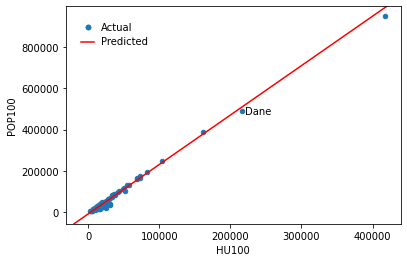

In [17]:
#Q11: What is the relationship between HU100 and POP100, visually?
ax = train.plot.scatter(x="HU100", y="POP100")
pts = test.plot.scatter(x="HU100", y="POP100", ax=ax)
line = ax.axline((0, intercept), slope=slope, color="red")

dane_hu100 = train[train["NAME"]=="Dane County"]["HU100"].values[0]
dane_pop100 = train[train["NAME"]=="Dane County"]["POP100"].values[0]
plt.text(dane_hu100+5000, dane_pop100, "Dane", va="center")

y = ax.get_ylim()[1] - 100000
x = ax.get_xlim()[0] + 20000
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]

plt.plot(x, y, marker="o", markersize=5)
plt.plot([x-(x_range/50), x+(x_range/50)], [y-(y_range/15), y-(y_range/15)], color="red")
plt.text(x+(x_range/25), y, "Actual", va="center")
plt.text(x+(x_range/25), y-(y_range/15), "Predicted", va="center")
None

In [18]:
#Q12: How many numbers in matrix A are between 2 and 5 (inclusive)?
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

gt2lt5 = (A >= 2) & (A <= 5)
gt2lt5.astype(int).sum()

12

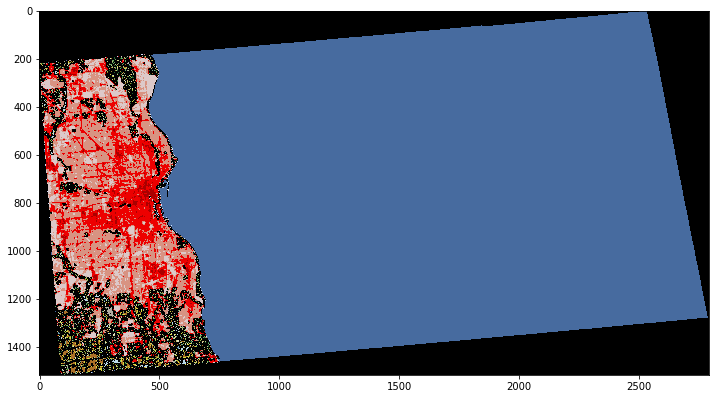

In [19]:
#Q13: How does Milwaukee County look?
land = rasterio.open("zip://../p6/land.zip!wi.tif")

mil = wi_counties[wi_counties["NAME"]=="Milwaukee County"]

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

matrix, _ = mask(land, mil.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, vmin=0, vmax=255, cmap = custom_cmap)

None

In [20]:
#Q14: What portion of Milwaukee County is "Open Water"?
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

o_h2o = land_use["open_water"]
open_water = len(matrix[matrix==o_h2o])
total = len(matrix[matrix!=0])
open_water/total

0.7963037455950543

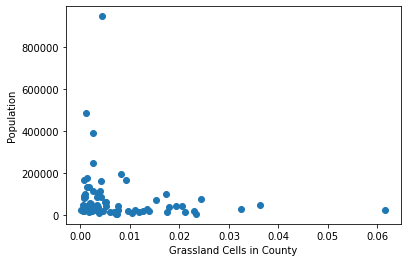

In [21]:
#Q15: What is the Relationship Between POP100 and ________________?
x_vals = []
y_vals = []

counties = wi_counties['NAME']
gl = land_use["grassland"]

for county in counties:  
    c = wi_counties[wi_counties["NAME"]==county]
    pop = c['POP100'].values[0]
    matrix, _ = mask(land, c.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    grassland = len(matrix[matrix==gl])
    total = len(matrix[matrix!=0])
    pct = grassland/total
    
    x_vals.append(pct)
    y_vals.append(pop)

plt.scatter(x_vals, y_vals)
plt.xlabel("Grassland Cells in County")
plt.ylabel("Population")
None

In [22]:
census_tracts = gpd.read_file("tracts.geojson").to_crs(land.crs)

In [23]:
def add_feature(geometry, feature): #for adding what the portion that is a land type
    global land
    global land_use
    feature_num = land_use[feature]
    
    matrix, _ = mask(land, geometry["geometry"], crop=True)
    matrix = matrix[0]
    feature = len(matrix[matrix==feature_num])
    total = len(matrix[matrix!=0])
    pct = feature/total
    
    return pct

def add_feature2(geometry, feature): #for adding quantity of a land type
    global land
    global land_use
    feature_num = land_use[feature]
    
    matrix, _ = mask(land, geometry["geometry"], crop=True)
    matrix = matrix[0]
    feature = len(matrix[matrix==feature_num])
    
    return feature

In [24]:
features_to_add = ["developed_med"]

for feature in features_to_add:
    geo_ids = list(census_tracts["GEOID"])
    vals_list = []
    for geo_id in geo_ids:
        df = census_tracts[census_tracts['GEOID']==geo_id]
        #pct = add_feature(df, feature)
        total = add_feature2(df, feature)
        vals_list.append(total)
    census_tracts[feature] = vals_list

In [25]:
train, test = train_test_split(census_tracts, random_state=320, test_size=0.25)

In [26]:
model16 = LinearRegression()

m17 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])

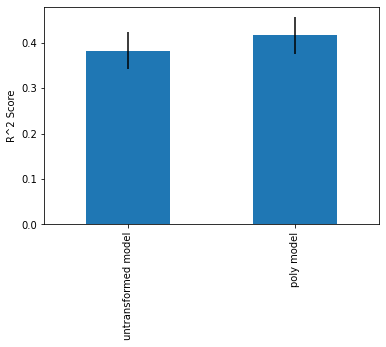

In [27]:
#Q16: How do the models you selected compare under cross validation?
m16_scores = cross_val_score(model16, train[['developed_med']], train["POP100"])
m16_mean = m16_scores.mean()
m16_std = m16_scores.std()

m17_scores = cross_val_score(m17, train[['developed_med']], train["POP100"])
m17_mean = m17_scores.mean()
m17_std = m17_scores.std()

avg = pd.Series({"untransformed model": m16_mean, "poly model": m17_mean})
std = pd.Series({"untransformed model": m16_std, "poly model": m17_std})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")
None

In [28]:
#Q17: How does your recommended model score against the test dataset?
#I recommend model 17 (pipeline model), which has a higher explained variance and a similar standard deviation using the same feature. 
m17.fit(train[['developed_med']], train["POP100"])
m17.score(test[['developed_med']], test["POP100"])

0.40029704465563754